# Case Study: Flow past a cylinder

We solve a relatively more challenging problem: flow past a 
circular cylinder. The geometry is as shown below:
![Geoetry](http://www.featflow.de/media/dfg_bench2_2d/geometry.png)

This problem was taken from the ["FEATFLOW/1995-DFG benchmark suite"](
http://www.featflow.de/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark2_re100.html).
Notice the slightly perturbed and unsymmetric geometry.

The kinematic viscosity is
given by $\nu = 0.001 = \mu/\rho$ and the inflow velocity profile is
specified as
$$  u(x, y, t) = \left(1.5 \cdot \frac{4y(0.41 - y)}{0.41^2}, 0\right),$$

which has a maximum magnitude of $1.5$ at $y = 0.41/2$. We do not
use any scaling for this problem since all exact parameters are known.

## FEniCS implementation

### Generate mesh and function space
FEniCS supports the creation of relatively complex meshes via a technique
called *constructive solid geometry* (CSG), which lets us define
geometries in terms of simple shapes (primitives) and set operations:
union, intersection, and set difference. The set operations are
encoded in FEniCS using the operators `+` (union), `*` (intersection),
and `-` (set difference). To access the CSG functionality in FEniCS,
one must import the FEniCS module `mshr` which provides the
extended meshing functionality of FEniCS.

In [1]:
from fenics import *
from mshr import *
import numpy as np
%matplotlib inline

The geometry for the cylinder flow test problem can be defined easily
by first defining the rectangular channel and then subtracting the
circle:

In [2]:
channel = Rectangle(Point(0, 0), Point(2.2, 0.41))
cylinder = Circle(Point(0.2, 0.2), 0.05, 16)
domain = channel - cylinder

Note that in the above, we passed 16 for the third argument when calling `Circle` to request explicitly using 16 segments to represent the circle. This is necessary to circumvent a bug in `mshr` as of release 2016.02, which would generate a triangle to represent the circle if the third argument was missing.

We may then generate the mesh by calling the function `generate_mesh`, plot the mesh, and save it to a file for inspection:

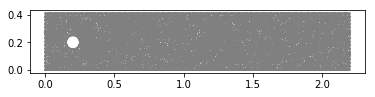

In [3]:
mesh = generate_mesh(domain, 64)
plot(mesh)
File('navier_stokes_cylinder/cylinder.pvd') << mesh

Here the argument `64` indicates that we want to resolve the geometry
with 64 cells across its diameter (the channel length).

We define the function spaces based on the mesh.

In [4]:
# Define function spaces
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

###  Specify boundary conditions
To solve the cylinder test problem, we only need to make a few minor
changes to the code we wrote for the channel flow test
case. Besides defining the new mesh, the only change we need to make
is to modify the boundary conditions and the time step size. The
boundaries are specified as follows:

In [5]:
inflow   = 'near(x[0], 0)'
outflow  = 'near(x[0], 2.2)'
walls    = 'near(x[1], 0) || near(x[1], 0.41)'
cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'

The last line may seem cryptic before you catch the idea: we want to pick
out all boundary points (`on_boundary`) that also lie within the 2D
domain $[0.1,0.3]\times [0.1,0.3]$. The only possible points are then the 
points on the circular boundary!

We then collect the boundary conditions into lists.

In [6]:
# Define inflow profile
inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')

# Define boundary conditions
bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
bcp = [bcp_outflow]

--- Instant: compiling ---
--- Instant: compiling ---
--- Instant: compiling ---
--- Instant: compiling ---


### Specify parameters

We specify density, viscosity, and timestep. We will set the time steps. 
relatively small time step to compute the solution (a time step that
is too large will make the solution blow up).

In [7]:
mu = 0.001         # dynamic viscosity
rho = 1            # density

T = 5.0            # final time
num_steps = 5000   # number of time steps
dt = T / num_steps # time step size

### Define the variational problems

The definition of the variational problem is the same as before.

In [8]:
# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

# Define functions for solutions at previous and current time steps
u_k = Function(V)
u_  = Function(V)

p_k = Function(Q)
p_  = Function(Q)

# Define expressions used in variational forms
f  = Constant((0, 0))
DT = Constant(dt)
mu = Constant(mu)

u_mid  = 0.5*(u_k + u)
n  = FacetNormal(mesh)

# Define variational problem for step 1
F1 = rho*dot((u - u_k) / DT, v)*dx \
   + rho*dot(dot(u_k, nabla_grad(u_k)), v)*dx \
   + inner(sigma(u_mid, p_k), epsilon(v))*dx \
   + dot(p_k*n, v)*ds - dot(mu*nabla_grad(u_mid)*n, v)*ds \
   - dot(f, v)*dx

a1 = lhs(F1)
L1 = rhs(F1)
A1 = assemble(a1)
[bc.apply(A1) for bc in bcu]

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_k), nabla_grad(q))*dx - (1/DT)*div(u_)*q*dx
A2 = assemble(a2)
[bc.apply(A2) for bc in bcp]

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - DT*dot(nabla_grad(p_ - p_k), v)*dx
A3 = assemble(a3)

Calling FFC just-in-time (JIT) compiler, this may take some time.


## Time-stepping

We can now perform time-stepping. We will also add a *progress bar* so that 
we can follow the progress of our computation. This can be done as follows:

In [9]:
progress = Progress('Time-stepping')
set_log_level(PROGRESS)

**Log levels and printing in FEniCS**. Notice the call to `set_log_level(PROGRESS)` which is essential to
make FEniCS actually display the progress bar. FEniCS is actually
quite informative about what is going on during a computation but the
amount of information printed to screen depends on the current log
level. Only messages with a priority higher than or equal to the
current log level will be displayed. The predefined log levels in
FEniCS are
`DBG`,
`TRACE`,
`PROGRESS`,
`INFO`,
`WARNING`,
`ERROR`, and
`CRITICAL`. By default, the log level is set to `INFO` which means
that messages at level `DBG`, `TRACE`, and `PROGRESS` will not be
printed. Users may print messages using the FEniCS functions `info`,
`warning`, and `error` which will print messages at the obvious log
level (and in the case of `error` also throw an exception and
exit). One may also use the call `log(level, message)` to print a
message at a specific log level.

We also make another change: since the system(s) of linear equations are 
significantly larger than for the simple channel flow test problem, we choose 
to use an iterative method instead of the default direct (sparse) solver used by
FEniCS when calling `solve`. Efficient solution of linear systems
arising from the discretization of PDEs requires the choice of both a
good iterative (Krylov subspace) method and a good
preconditioner. For this problem, we will simply use the biconjugate
gradient stabilized method (BiCGSTAB) and the conjugate gradient method. This can be done by adding the
keywords `bicgstab` or `cg` in the call to `solve`. You can determine which solvers
are available by running the command
```
list_krylov_solver_methods()
```
Note that the output may not be displaced in the Jupyter Notebook but will be shown in the terminal where
you started Jupyter Notebook.

We also specify suitable preconditioners to speed up the 
computations. You can determine which solvers
are available by running the command
```
list_krylov_solver_preconditioners()
```

For example, we may use `petsc_amg` or `ilu`.
```
solve(A1, u1.vector(), b1, 'bicgstab', 'petsc_amg')
solve(A2, p1.vector(), b2, 'bicgstab', 'petsc_amg')
solve(A3, u1.vector(), b3, 'cg', 'sor')
```

In addition, to be able to postprocess the computed solution in ParaView,
we store the solution to a file in each time step. 
If you have HDF5 installed, you may use the `xdmf` file format, 
which has a few advantages. First, the storage is
much more efficient, both in terms of speed and file sizes. Second,
`.xdmf` files work in parallell, both for writing and reading
(postprocessing). Much like `.pvd` files, the actual data will not be
stored in the `.xdmf` file itself, but will instead be stored in a
(single) separate data file with the suffix `.hdf5` which is an
advanced file format designed for high-performance computing.
However, if HDF5 is not available, we will still use `pvd` files.

In [10]:
if 'HDF5File' in globals():
    # Use XDMF files
    xdmffile_u = XDMFFile('navier_stokes_cylinder/velocity.xdmf')
    xdmffile_p = XDMFFile('navier_stokes_cylinder/pressure.xdmf')
else:
    vtkfile_u = File('navier_stokes_cylinder/velocity.pvd')
    vtkfile_p = File('navier_stokes_cylinder/pressure.pvd')

Similarly, we may also store the solution using a FEniCS `TimeSeries`. This allows us
to store the solution not for visualization, but for later reuse in a
computation as we will see in the next section. Using a `TimeSeries`
it is easy and efficient to read in solutions from certain points in
time during a simulation. The `TimeSeries` class also uses the HDF5
file format for efficient storage and access to data, so we will 
enable it only if HDF5 is available.

In [11]:
if 'HDF5File' in globals():
    # Create time series (for use in reaction_system.py)
    timeseries_u = TimeSeries('navier_stokes_cylinder/velocity_series')
    timeseries_p = TimeSeries('navier_stokes_cylinder/pressure_series')

The following is the complete code for time-stepping. We will print `max(u)` at each step. Please be advised that this example program is considerably more demanding than our previous examples in terms of CPU time and memory, but it should be possible to run the program on a reasonably modern laptop.

Note that the progress log may not be displayed inside the Jupyter Notebook but in the terminal where JN was started.

In [12]:
import sys

out_interval = num_steps / 100;

# Time-stepping
t = 0
for k in range(1,num_steps+1):
    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1, 'bicgstab', 'ilu')

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2, 'bicgstab', 'ilu')

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3, 'cg', 'sor')

    # Plot solution
    # plot(u_, title='Velocity')
    # plot(p_, title='Pressure')

    if k%out_interval ==0 or k==num_steps:
        print('u max:', u_.vector().array().max())

        # Save solution to files
        if 'HDF5File' in globals():
            xdmffile_u.write(u_, t)
            xdmffile_p.write(p_, t)
        else:
            vtkfile_u << (u_, t)
            vtkfile_p << (p_, t)

    # Update previous solution
    u_k.assign(u_)
    p_k.assign(p_)

    # Update progress bar
    progress.update(t / T)
    
interactive()    

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
u max: 1.92762010483
u max: 2.01520053123
u max: 2.22347152812
u max: 2.21720346441
u max: 2.19623569704
u max: 2.17779478429
u max: 2.16216516992
u max: 2.15205491193
u max: 2.14885171706
u max: 2.15174188487
u max: 2.15719648979
u max: 2.15987132177
u max: 2.15539813761
u max: 2.14362397166
u max: 2.1298462418
u max: 2.12234017814
u max: 2.12691842862
u max: 2.14213090558
u max: 2.15892963584
u max: 2.16571572717
u max: 2.15619093737
u max: 2.13504630758
u max: 2.11711902332
u max: 2.1184334594
u max: 2.14314658182
u max: 2.17741113218
u max: 2.19719858855
u max: 2.18603504752
u max: 2.15038678476
u max: 2.13082446614
u max: 2.13928040317
u max: 2.17309063317
u max: 2.22360359133
u max: 2.2389764105
u max: 2.20471231223
u max: 2.14761011222
u max: 2.16956636838
u max: 2.15418814745
u max: 

The following figure shows the velocity and pressure at final time visualized in ParaView. 
It uses the *Glyph* filter to visualize the vector velocity field.

<a href="https://fenicsproject.org/pub/tutorial/html/mov/navier_stokes_cylinder.ogv" target="_blank"><img src="https://fenicsproject.org/pub/tutorial/html/fig/navier_stokes_cylinder_velocity.png" alt="Movie" width="800" border="10" /></a>